In [199]:
import math
import json
import re
import copy

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# Load an example dataset with long-form data
#fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
#plt = sns.lineplot(x="timepoint", y="signal",
#             hue="region", style="event",
#             data=fmri)


#plt.show()

In [200]:

#with open('../1_pop_cleaning/communes_VD_clean.json', 'r') as cf:
#    communes = json.load(cf)
#    for c in communes:
#        for hy in c["hab_year"]:
#            hy["pop"] = int(hy["pop"])
#            hy["year"] = int(hy["year"])
#cdata = pd.DataFrame(communes)
#cdata

In [225]:
class HabYear:
    def __init__(self, json_hy):
        self.year = int(json_hy["year"])            
        self.pop = int(json_hy["pop"]),
        self.unit = json_hy["unit"].strip() if "unit" in json_hy else "undefined"

class Commune:
    COMMUNES_NAME_REGEX = re.compile(r"\W\(?Gemeinde\)?")
    def __init__(self, json_commune):
        self.name = self.COMMUNES_NAME_REGEX.sub("",json_commune["name"])
        self.canton = json_commune["canton"]
        self.url = json_commune["url"]
        self.firstmention = json_commune["firstmention"] if "firstmention" in json_commune else None
        self.notes = json_commune["notes"] if "notes" in json_commune else ""
        self.hab_year = [HabYear(hy) for hy in json_commune["hab_year"]]
        self.raw_hab_year = copy.deepcopy(commune["hab_year"])
        

# Loading data & assembling reviewedCommunes with non-reviewed communes

In [221]:

#with open('../1_pop_cleaning/communes_V2_checkpoint_1555579436131.json', 'r') as cf:
with open('../1_pop_cleaning/communes_V2_checkpoint_1558469560478.json', 'r') as cf:
    data = json.load(cf)
    

In [222]:

reviewedCommunes = data["reviewedCommunes"]
communesToReview = data["communesToReview"]

# remember that some are reviewed and some not
for commune in reviewedCommunes:
    commune["hand_reviewed"] = True
for commune in communesToReview:
    commune["hand_reviewed"] = False
    
print("communes[0].keys()")
print(reviewedCommunes[0].keys())
print("communesToReview[0].keys()")
print(communesToReview[0].keys())

communes[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'problems', 'warnings', 'hand_reviewed'])
communesToReview[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'notes', 'problems', 'warnings', 'hand_reviewed'])


In [223]:
columns_communes = ["name","canton","url","firstmention","hab_year","raw_hab_year","notes"]
communes_name_regex = re.compile(r"\W\(?Gemeinde\)?")

communes = reviewedCommunes+communesToReview
communes = [
    {
        "name": communes_name_regex.sub("",commune["name"]),
        "canton": commune["canton"],
        "url": commune["url"],
        "firstmention": commune["firstmention"] if "firstmention" in commune else -1,
        "hab_year": [
            {
                "year": int(hy["year"]),
                "pop": int(hy["pop"]),
                "unit": hy["unit"].strip() if "unit" in hy else "undefined"
            } for hy in commune["hab_year"]
        ],
        "notes": commune["notes"] if "notes" in commune else ""
    }
    for commune in communes
]
for commune in communes:
    commune["raw_hab_year"] = copy.deepcopy(commune["hab_year"])

# Drop thurgau for now
print(len(communes))
TGcommunes = [c for c in communes if c["canton"]=="TG"]
communes = [c for c in communes if c["canton"]!="TG"]
print(len(communes))

dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
#dfcommunes

2242
2162


In [226]:
# class version

columns_communes = ["name","canton","url","firstmention","hab_year","raw_hab_year","notes"]

communes = reviewedCommunes+communesToReview
communes = [Commune(json_commune)
    for json_commune in communes
]

# Drop thurgau for now
print(len(communes))
TGcommunes = [c for c in communes if c.canton=="TG"]
communes = [c for c in communes if c.canton!="TG"]
print(len(communes))

#dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
#dfcommunes

2242
2162


# Available data across time

min(years) =  1177
Number of observations per year:
(1149.999, 1200.0]       3
(1200.0, 1250.0]         4
(1250.0, 1300.0]         9
(1300.0, 1350.0]        19
(1350.0, 1400.0]        28
(1400.0, 1450.0]       108
(1450.0, 1500.0]       205
(1500.0, 1550.0]        82
(1550.0, 1600.0]       118
(1600.0, 1650.0]       211
(1650.0, 1700.0]       269
(1700.0, 1750.0]       255
(1750.0, 1800.0]      1329
(1800.0, 1850.0]      2631
(1850.0, 1900.0]         0
dtype: int64


Text(0.5, 1.0, 'Number of observations across time')

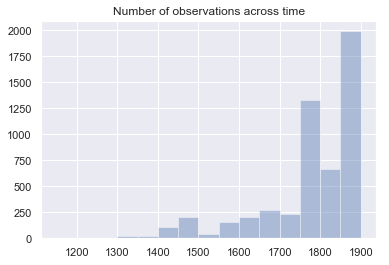

In [228]:
years_bins = range(1150,1901,50)

years = [hy.year for c in communes for hy in c.hab_year if hy.year<=1850]
print("min(years) = ", min(years))

print("Number of observations per year:")
print(pd.Series(years).value_counts(bins=years_bins,sort=False))

sns.distplot(years, bins=years_bins, kde=False, rug=False).set_title('Number of observations across time')

Text(0.5, 1.0, 'Number of communes with first observation before year Y')

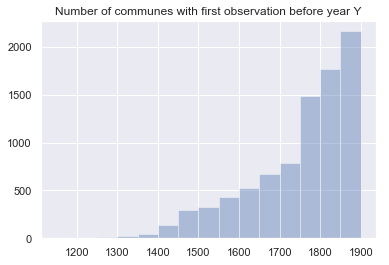

In [229]:


first_years = [min([y for hy in c.hab_year for y in [hy.year] if y<=1850]+[1850]) for c in communes ]

sns.distplot(first_years, bins=years_bins, hist_kws=dict(cumulative=True),kde=False,rug=False).set_title("Number of communes with first observation before year Y")

# Unit transformation

In [230]:
units = [hy.unit  for c in communes for hy in c.hab_year if hy.year<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

Number of each type of units:
Einw                                               2814
Feuerstätten                                        157
Haushalte                                           146
Feuerstellen                                         28
Häuser                                               25
Haushaltungen                                        23
Einw Kirchgem.                                       13
Steuerpflichtige                                     11
Einw. Kirchgem                                        6
Erwachsene                                            6
Einw Feuerschaukreis                                  6
Kanoniker                                             6
Hofstätten                                            4
Kommunikanten                                         3
Herdstellen                                           3
Herdstätten                                           3
Haushalt                                              3
undefined         

In [231]:
pd.Series(units).unique()

array(['Haushalte', 'Einw', 'Feuerstätten', 'Haushaltungen', 'Häuser',
       'Kirchgenossen', 'Steuerpflichtige', 'Erwachsenen',
       'Einw Feuerschaukreis', 'Erwachsene', 'Kanoniker', 'Höfe',
       'Herdstellen', 'Hofstätten', 'Pesttote', 'Fam', 'Kommunikanten',
       'Feuerstellen', 'Einw Kirchgem.', 'Juden', 'Einw outlier',
       'Feuerstätten (mit Sermuz, heute Gem', 'Bürger',
       '(Pfarrei einschliesslich Molondin und Vuissens)', 'Haushalt',
       'Einwohner', '', 'Hofgenossen', 'Hausväter', 'Einw Pedrinate',
       'Herdstätten', 'undefined', 'Beisassen', 'Einw. Kirchgem',
       'Haushalte Kirchgem'], dtype=object)

In [232]:
unit_einw_1 = ['Beisassen',
'Bürger',
'Einw',
'Einw Feuerschaukreis',
'Einw Kirchgem.',
'Einw. Kirchgem', 'Einwohner',
'Kirchgenossen', 'Kommunikanten'
]
unit_haushalte_5 = [
'Erwachsene', 'Erwachsenen', 'Fam', 'Feuerstellen', 'Feuerstätten',
'Feuerstätten (mit Sermuz, heute Gem', 'Haushalt', 'Haushalte',
'Haushalte Kirchgem', 'Haushaltungen', 'Hausväter', 'Herdstellen',
'Herdstätten', 'Hofgenossen', 'Hofstätten', 'Häuser', 'Höfe',
'Steuerpflichtige',
]
accepted_units = unit_einw_1+unit_haushalte_5

### Finding the conversion factor

In [235]:

def one1one5(a,b):
    return (a.unit in unit_einw_1 and b.unit in unit_haushalte_5) or (a.unit in unit_haushalte_5 and b.unit in unit_einw_1)

def detect_duplicated_years(commune):
    # create one dict with one entry per year
    # for each year:
    # - if no year in dict, add it
    # - if a year already there, add it to the list
    # filter the dict on the years where len()>1
    year_dict = {}
    for hy in commune.hab_year:
        if hy.year in year_dict:
            year_dict[hy.year].append(hy)
        else:
            year_dict[hy.year] = [hy]
    duplicates = {y:sorted(hys,key=lambda hy: -hy.pop) for y,hys in year_dict.items() if len(hys)>1}
    return duplicates

# find duplicates
duplicates = [(c.name,c.canton,y,hys) for c in communes for y,hys in (detect_duplicated_years(c)).items() if one1one5(hys[0],hys[1])]

dfduplicates = pd.DataFrame([{
    "commune": cname,
    "canton": canton,
    "year": y,
    "pop_einw": hys[0]["pop"],
    "pop_haus": hys[1]["pop"],
    "ratio": hys[0]["pop"] / hys[1]["pop"],
    "unit_haus": hys[1]["unit"]} for cname, canton, y, hys in duplicates])
dfduplicates = dfduplicates.sort_values(["year","unit_haus","commune"])
print("Number of double Haushaltungen-Einw data")
print(len(duplicates))
dfduplicates

TypeError: bad operand type for unary -: 'tuple'

In [210]:
def boxplot_condition(df, groupings, ax=plt):
    groupings = [(unit, f, f(dfduplicates)) for unit, f in groupings]
    ax.boxplot(
        [df.ratio.loc[condition] for unit, f, condition  in groupings],
        labels = [unit+f" ({np.sum(condition)}, mean: {np.round(np.mean(df.ratio.loc[condition]),2)})" for unit, f, condition in groupings]
        )
    #ax.xticks(rotation=10)
    ax.tick_params(labelrotation=10)

    

NameError: name 'df' is not defined

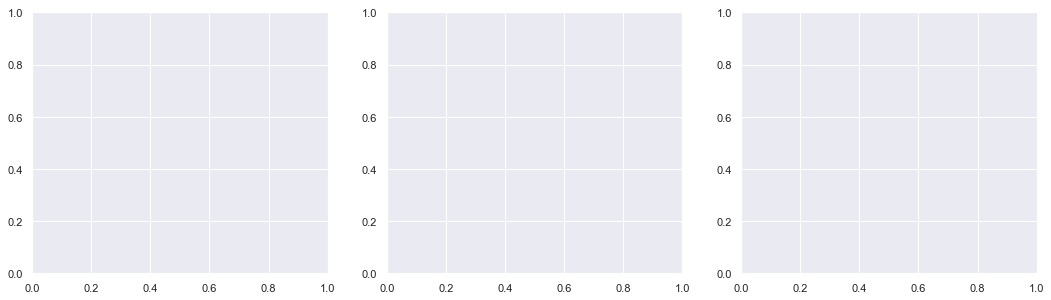

In [211]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4.8))

haus_units = [
    ("all", lambda df: df.pop_haus>0),
    ("Haushalte", lambda df: (df.unit_haus =="Haushaltungen") | (df.unit_haus=="Haushalte")),
    ("Häuser", lambda df: df.unit_haus=="Häuser"),
    ("Feuerstätten", lambda df: df.unit_haus=="Feuerstätten"),
    ("Steuerpflichtige", lambda df: df.unit_haus=="Steuerpflichtige")
]

haus_years= [
    ("all", lambda df: df.year>=0),
    (">1750", lambda df: df.year>1750),
    ("1650-1749", lambda df: (df.year>1650) & (df.year<=1750)),
    ("<1650", lambda df:  df.year<=1650),
]

haus_cantons = [
    ("all", lambda df: df.pop_haus>0),
    ("VD", lambda df: df.canton =="VD"),
    ("others", lambda df: df.canton !="VD"),
]

boxplot_condition(df, haus_units, ax1)
ax1.set_title("conversion factor boxplot depending on type of unit")
boxplot_condition(df, haus_years, ax2)
ax2.set_title("conversion factor boxplot depending on year of observation")
boxplot_condition(df, haus_cantons, ax3)
ax3.set_title("conversion factor boxplot depending on canton")
None

In [ ]:
conversion_factor = np.mean(dfduplicates.ratio)
print(f"conversion factor: {np.round(conversion_factor,3)}")

### Doing the conversion

Remove non-Einw data in duplicated years, as well as non-accepted units

In [ ]:
for c in communes:
    duplicates = detect_duplicated_years(c)
    c["hab_year"] = [hy for hy in c["hab_year"] if hy["year"] not in duplicates or hy["unit"]=="Einw"]
    c["hab_year"] = [hy for hy in c["hab_year"] if hy["unit"] in accepted_units]

In [ ]:
for c in communes:
    to_delete = []
    #print(c["hab_year"])
    for i,hy in enumerate(c["hab_year"]):
        if hy["unit"] in unit_haushalte_5:
            hy["original_unit"] = hy["unit"]
            hy["einw_conversion_factor"] = conversion_factor
            hy["pop"] = int(np.round(conversion_factor*hy["pop"]))
        hy["unit"] = "Einw"    
    

In [ ]:
c = communes[1]
duplicates = detect_duplicated_years(c)
duplicates
c

In [ ]:
[hy for hy in c["hab_year"] if hy["year"] not in duplicates or hy["unit"]=="Einw"]

In [ ]:
units = [hy["unit"]  for c in communes for hy in c["hab_year"] if hy["year"]<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

In [ ]:
dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
dfcommunes

In [ ]:
dfcommunes.to_csv("communes_units_converted.csv", sep=";")

In [ ]:
with open('communes_units_converted.json', 'w') as json_file:
  json.dump(communes, json_file)

In [ ]:
communes[0]

# Doing the interpolation

Create an interpolator per commune:

In [ ]:
def interpolator(data_points):
    """Returns a linear interpolator from the given dataPoints
    @param {*} dataPoints an array of length 2 arrays, each sub-array is a coordinate with sub-array[0]=x, sub-array[1]=y
    @returns interpolate(x) a function taking a value x and returning the linear interpolation of y at x, or null if x is outside the x range of dataPoints
    """
    data_points = sorted(data_points, key=lambda hy:hy[0])
    def interpolate(x):
        if data_points[0][0]==x:
            return data_points[0][1]
        for i in range(1,len(data_points)):
            if data_points[i][0]>=x and data_points[i-1][0]<=x:
                a = data_points[i-1]
                b = data_points[i]
                return a[1]+ (b[1]-a[1])/(b[0]-a[0]) * (x-a[0])
        return None
    return interpolate
    

In [ ]:
def exponential_interpolator(data_points):
    linear_interpolator = interpolator([(dp[0],math.log(dp[1])) for dp in data_points])
    def exp_interpolate(x):
        log_result = linear_interpolator(x)
        if log_result:
            return math.exp(log_result)
        else: return None
    return exp_interpolate

In [ ]:
a = [(0.01,0.1),(1,1),(2,3),(3,6)]
print(f"a = {a}")
x=2.5
interp = interpolator(a)
print(f"interp({x}) = {interp(x)}")
expterp = exponential_interpolator(a)
print(f"expterp({x}) = {expterp(x)}")

add exp. interpolator to each commune:

In [212]:
for c in communes:
    interp_space = [(hy["year"],hy["pop"]) for hy in c["hab_year"]]
    interp = exponential_interpolator(interp_space)
    c["interpolator"] = interp

## How to extrapolate for communes without data?

### options:
- compute year-by-year growth rates for communes with data
   -> use the average per-year growth rate to find a growth-rates time series back in time
   -> use this growth-rate time series to go back in time
- use timespans of size X: compute average growth rate in each timespan
    -> go back in time with those growth rates
    
### proposition:
- each hy has a "type" entry with possible values: "original", "interpolated", "extrapolated"
- define function compute_growth_rate(c,y1,y2):
    return None if no data surrounding y1, y2
    return growth rate if it exists
- iterate over communes and timespans
    compute_growth_rate(...)
    -> growth rate of timespan = avg of computed growth rate
    
## TODO:
- compute_growth((x1,y1),(x2,y2))
- compute_growth(c,y1,y2)